In [1]:
! pip install split-folders

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchsummary import summary
import splitfolders
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
transform = transforms.Compose([transforms.ToTensor()])

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
%cd /content/drive/MyDrive/ML/Assigments/Assign09/

/content/drive/MyDrive/ML/Assigments/Assign09


In [7]:
# Split the folder into train and test and Prepare train and test datasets, Loaders

In [8]:
splitfolders.ratio("HAR_Images", output="TrainTest",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False) # default values

Copying files: 1400 files [00:28, 48.76 files/s]


In [9]:
train_data = datasets.ImageFolder('TrainTest/train', transform = transform)
test_data = datasets.ImageFolder('TrainTest/val', transform = transform)

In [10]:
torch.manual_seed(42)
train_loader = DataLoader(train_data, batch_size = 32, shuffle=True,  drop_last = True)
test_loader = DataLoader(test_data, batch_size= 32,  drop_last = True)

class_names = train_data.classes # classes or labels or categories

print(class_names)
print(f'Training images available: {len(train_data)}')
print(f'Testing images available:  {len(test_data)}')

['Catch', 'Clap']
Training images available: 1120
Testing images available:  280


Display a batch of images

In [11]:
for images,labels in train_loader:
    break
images.shape

torch.Size([32, 3, 64, 64])

In [12]:
labels

tensor([0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 1, 1, 1, 0])

In [13]:
#np.transpose(im.numpy(), (1, 2, 0)).shape

Label: [0 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 0 0 1 0 1 0 1 1 1 0]
Class: Catch Clap Clap Catch Catch Clap Catch Clap Catch Catch Catch Clap Catch Catch Catch Clap Clap Clap Clap Clap Catch Catch Catch Catch Clap Catch Clap Catch Clap Clap Clap Catch


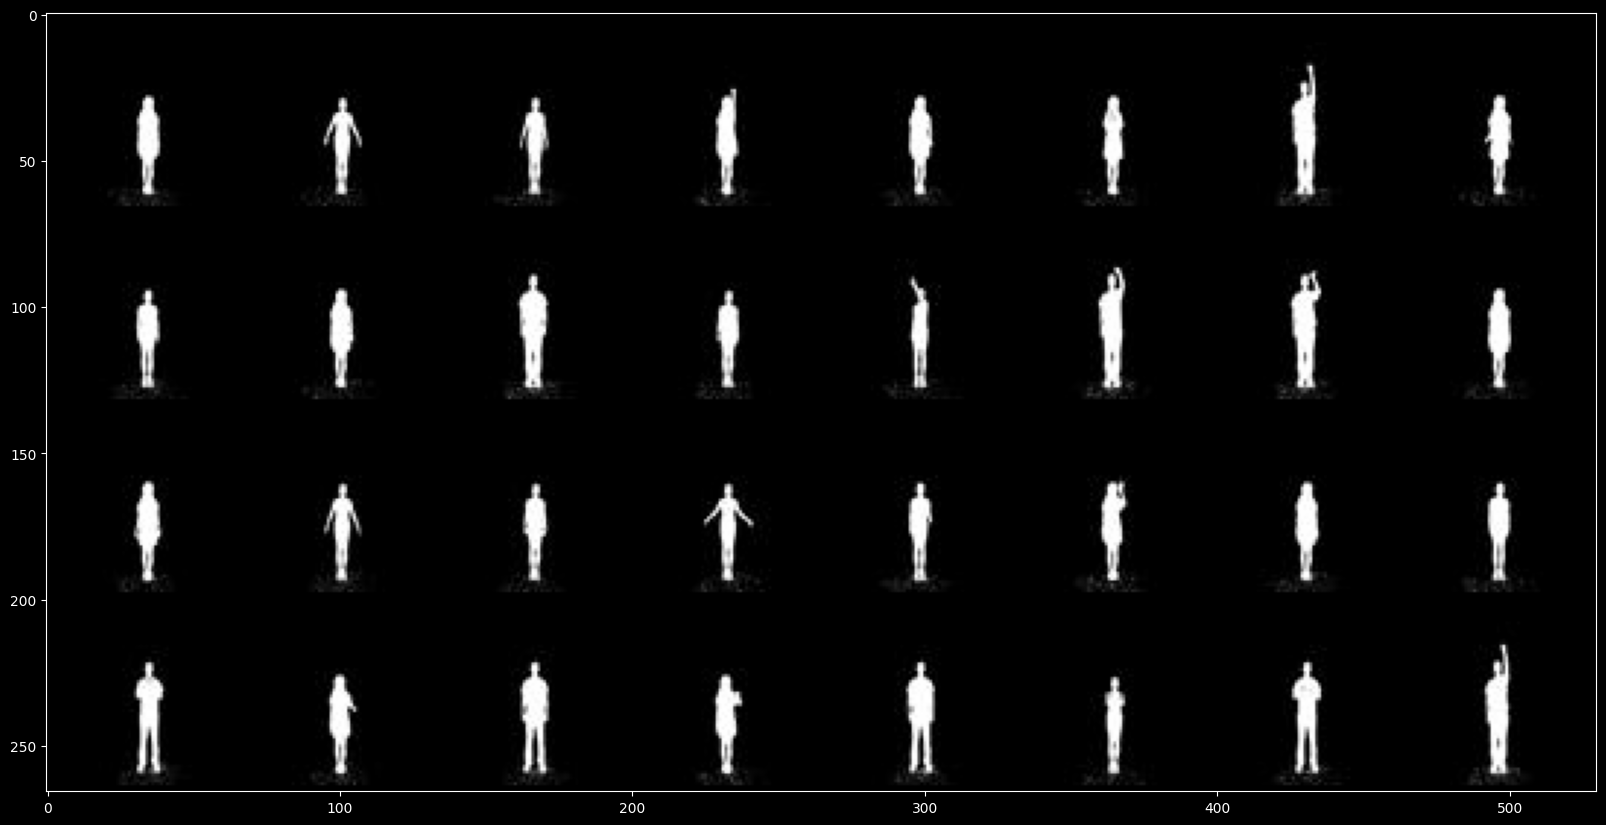

In [14]:
# Print the labels

print('Label:', labels.numpy())
print('Class:', *np.array([class_names[i] for i in labels]))

im = make_grid(images)


# Print the images

plt.figure(figsize=(20,16))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [15]:
model = nn.Sequential(
          nn.Linear(12288,2048),  # 3 x 64 x 64 = 12,288
          nn.ReLU(),
          nn.Linear(2048,2048),
          nn.ReLU(),
          nn.Linear(2048,1024),
          nn.ReLU(),
          nn.Linear(1024,512),
          nn.ReLU(),
          nn.Linear(512,256),
          nn.ReLU(),
          nn.Linear(256,128),
          nn.ReLU(),
          nn.Linear(128,64),
          nn.ReLU(),
          nn.Linear(64,2),
          )
model

Sequential(
  (0): Linear(in_features=12288, out_features=2048, bias=True)
  (1): ReLU()
  (2): Linear(in_features=2048, out_features=2048, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2048, out_features=1024, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1024, out_features=512, bias=True)
  (7): ReLU()
  (8): Linear(in_features=512, out_features=256, bias=True)
  (9): ReLU()
  (10): Linear(in_features=256, out_features=128, bias=True)
  (11): ReLU()
  (12): Linear(in_features=128, out_features=64, bias=True)
  (13): ReLU()
  (14): Linear(in_features=64, out_features=2, bias=True)
)

In [16]:
epochs = 30
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),momentum = 0.9, lr = 0.01) #change 0.001 ro 0.01 because our set is smaller

losses    = torch.zeros(epochs)
trainAcc  = []
testAcc   = []


  # loop over epochs
for epoch in range(epochs):

    model.train()
    model.to(device)
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:
      X = X.reshape(32,12288) # Reshaping 4D to 2D
      X = X.to(device)
      y = y.to(device)

      ypred =  model(X)
      loss = lossfun(ypred,y)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      batchLoss.append(loss.item())

      ypred = ypred.cpu()
      y = y.cpu()

      acc = 100 * torch.mean((torch.argmax(ypred, dim=1) == y).float())
      batchAcc.append(acc)

    trainAcc.append( np.mean(batchAcc) )

    losses[epoch] = np.mean(batchLoss)

    # TESTING


    model.eval()
    with torch.no_grad():

        for X,y in test_loader:
            X = X.reshape(32,12288)
            X = X.to(device)
            y = y.to(device)


            ypred =  model(X)
            ypred = ypred.cpu()
            y = y.cpu()

    testAcc.append( 100*torch.mean((torch.argmax(ypred,axis=1)==y).float()) )
    if (epoch % 5) == 0:
      print(f'epoch: {epoch}   loss: {loss.item()}')




epoch: 0   loss: 0.6925328969955444
epoch: 5   loss: 0.6913371682167053
epoch: 10   loss: 0.6758774518966675
epoch: 15   loss: 0.07097417116165161
epoch: 20   loss: 0.04233121499419212
epoch: 25   loss: 0.0003661930386442691


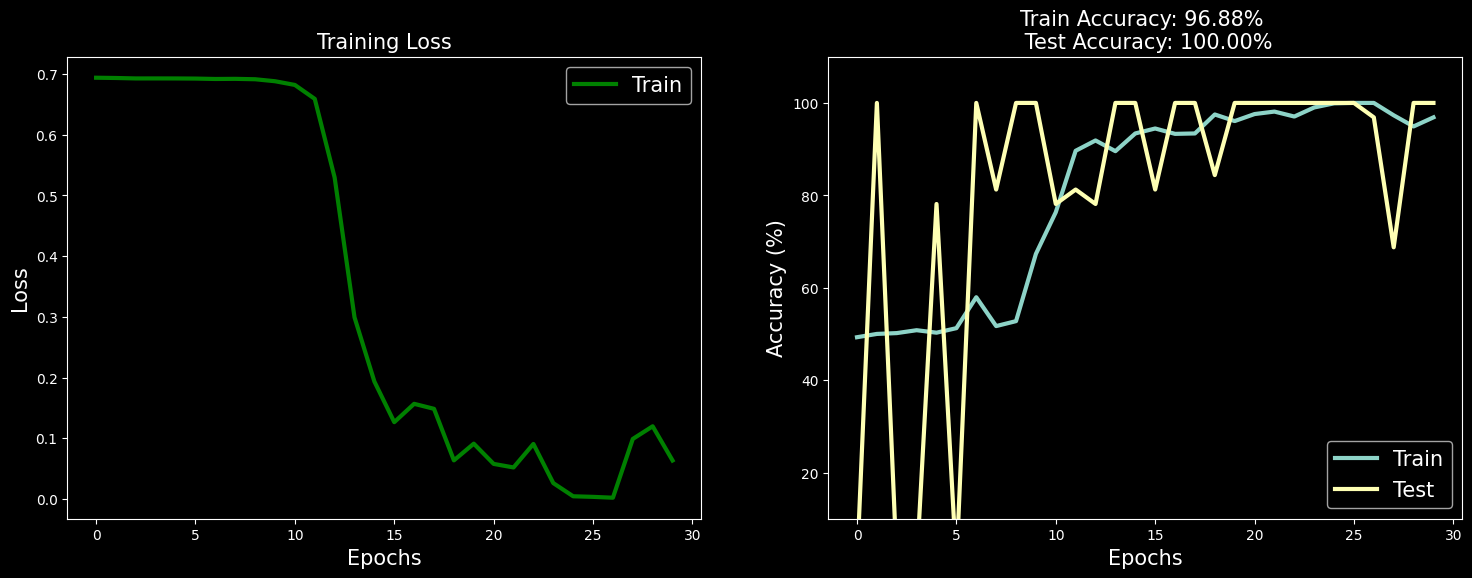

In [17]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()